# Objectives

PRIDE Doppler Data Characterization Script
------------------------------------------
This script performs a detailed analysis of **PRIDE Doppler data** for selected space missions.
It processes Fdets files to compute statistics on Doppler noise and SNR, filters bad data, and produces various plots.

**Main features**:
- Extraction of Doppler data from PRIDE observations.
- Statistical filtering using z-score outlier detection.
- Computation of user-defined parameters (SNR, Doppler noise).
- Optional plotting of:
    - Allan deviation curves
    - Best-fit Gaussian distributions
    - Filtered vs. unfiltered data
- Aggregation of results at experiment and mission level.

Flags are provided to enable/disable certain features. 

NOTE: When running the script for the first time, the **RUN_EXPERIMENTS_STATISTICS_FLAG** must be set to **True**.

**Author**: Luigi Gisolfi

**Date**: 2025/07/24

In [1]:
# Import statements
from pride_characterization_library import PrideDopplerCharacterization
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import copy
import numpy as np
from scipy.stats import norm
import random
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import os
from collections import defaultdict
from datetime import timezone
import datetime
import shutil

In [2]:
pride = PrideDopplerCharacterization() # create PRIDE Object
process_fdets = pride.ProcessFdets() # create Process Fdets Object
utilities = pride.Utilities() # create Utilities Object
analysis = pride.Analysis(process_fdets, utilities) # create Analysis Object

In [3]:
############################################################ SET THE FLAGS ###########################################################################
RUN_EXPERIMENTS_STATISTICS_FLAG = False # if True, creates the outputs from which the analysis is carried out.
ALLAN_DEVIATIONS_FLAG = False # if True, creates and shows the Overlapping Allan Deviation plots.
PLOT_GAUSSIAN_FLAG = False # if True, it plots the best fit Gaussian on top of Doppler noise distribution
COMPARE_FILTERS_FLAG = False # if True, it plots the original data vs the z-score filtered one.
BAD_OBSERVATIONS_FLAG = True # if True, it 1) plots the observations as flagged and 2) removes them from the final statistics for mean FoM computation
######################################################################################################################################################

In [4]:
# Select preferred start date end end date to perform the analysis
start_date = datetime.datetime(2000, 1, 1, tzinfo=timezone.utc)
end_date =  datetime.datetime(2024, 12, 31, tzinfo=timezone.utc)
missions_to_analyse = ['mex'] # select only the preferred mission names for which to perform the analysis

In [5]:
# change this to your folder containing PRIDE data
root_dir = f'/Users/lgisolfi/Desktop/PRIDE_DATA_NEW/analysed_pride_data/' 

In [6]:
# Based on start and end dates, it digs into the folder structure and looks for experiments, creating
# the "experiments_to_analyse" dictionary 
yymm_folders_to_consider = utilities.list_yymm(start_date, end_date)
months_list = list(yymm_folders_to_consider.keys())
days_list = [item for sublist in yymm_folders_to_consider.values() for item in sublist]
experiments_to_analyze = defaultdict(list)
yymmdd_folders_per_mission = defaultdict(list)

for mission_name in missions_to_analyse:
    mission_root = os.path.join(root_dir, mission_name)
    if not os.path.exists(mission_root):
        print(f"⚠️  Warning: Mission root path '{mission_root}' does not exist.")
        continue

    for yymm_folder in months_list:
        if mission_name == 'vex' and yymm_folder != '1401':
            continue
        month_folder_name = f"{mission_name}_{yymm_folder}"
        month_folder_path = os.path.join(mission_root, month_folder_name)
        if not os.path.exists(month_folder_path):
            continue  # continue to next yymmdd_folder
        for yymmdd in days_list:
            day_folder_name = f"{mission_name}_{yymmdd}"
            day_folder_path = os.path.join(month_folder_path, day_folder_name)
            if not os.path.exists(day_folder_path):
                continue  # continue to next yymmdd_folder
            yymmdd_folders_per_mission[mission_name].append(yymmdd)
            
if not yymmdd_folders_per_mission:
    print(f'No files found between {start_date} and {end_date} for mission: {mission_name.upper()}.\nAborting...\n')
    exit()
experiments_to_analyze = yymmdd_folders_per_mission # this is a dict, e.g. {'juice': [juice_YYMMDD], 'mex':[mex_YYMMDD]}

In [7]:
# Create empty dictionaries to be filled with meaningful values
mean_rms_user_defined_parameters = defaultdict(list)
mean_elevations = defaultdict(list)
color_dict = defaultdict(list)

In [8]:
# Hz = 5 mHz - Defines the highest acceptable value of mean Doppler noise for a given pass over a station
bad_observations_mean_doppler_filter = 0.005 

In [9]:
# Loop through missions and experiments
for mission_name, yymmdds in yymmdd_folders_per_mission.items():
    yymmdd_folders = [mission_name + '_' + yymmdd for yymmdd in yymmdds]
    yymm_folders = [mission_name + '_' + yymmdd[:4] for yymmdd in yymmdds]
    experiment_names = [utilities.find_experiment_from_yymmdd(yymmdd) for yymmdd in yymmdds]

    if BAD_OBSERVATIONS_FLAG and mission_name == 'mro':
        BAD_OBSERVATIONS_FLAG = False

    for yymm_folder, yymmdd_folder, experiment_name in zip(yymm_folders, yymmdd_folders, experiment_names):
        fdets_folder_path = f'/Users/lgisolfi/Desktop/PRIDE_DATA_NEW/analysed_pride_data/{mission_name}/{yymm_folder}/{yymmdd_folder}/input/complete' #or insert your path
        output_dir = f'/Users/lgisolfi/Desktop/PRIDE_DATA_NEW/analysed_pride_data/{mission_name}/{yymm_folder}/{yymmdd_folder}/output/' #or insert your path

        if RUN_EXPERIMENTS_STATISTICS_FLAG:
            if os.path.exists(output_dir):
                print(f'Deleting directory {output_dir}')
                shutil.rmtree(output_dir)
            horizons_target = utilities.mission_name_to_horizons_target(mission_name) # get target name from Horizons
            print(f'Creating Outputs for mission: {mission_name} (Horizons Code: {horizons_target})...')
            # Get list of FDETS files
            dir_path = fdets_folder_path
            files_list = []
            station_ids = []
            for file in os.listdir(dir_path):
                if file.startswith('Fdets') and file.endswith('r2i.txt'):
                    files_list.append(os.path.join(dir_path, file))
            # Extract data
            extracted_data_list = process_fdets.extract_folder_data(dir_path)

            # Uncomment the following line to plot the filtered data in the outputs (instead of the original PRIDE data).
            #extracted_data_list = analysis.two_step_filter(extracted_data_list)

            for extracted_data in extracted_data_list:
                station_id = extracted_data['receiving_station_name']
                for file_name in files_list:
                    if station_id != process_fdets.get_station_name_from_file(file_name):
                        continue
                    else:
                        # Plot user-defined parameters (doppler noise, SNR, fdets)
                        analysis.plot_user_defined_parameters(
                            extracted_data,
                            save_dir = os.path.join(output_dir, 'user_defined_parameters'),
                            plot_snr = True,
                            plot_doppler_noise = True,
                            plot_fdets= True,
                            suppress = True
                        )
                        # Plot elevation for each file (station)
                        analysis.get_elevation_plot(
                            [file_name],
                            horizons_target,
                            [station_id],
                            mission_name =mission_name ,
                            suppress = True,
                            save_dir = os.path.join(output_dir, 'elevation')
                        )
                        station_ids.append(station_id) # Append station_id to list station_ids

            # Plot SNR and Doppler Noise statistics
            analysis.get_all_stations_statistics(
                fdets_folder_path = fdets_folder_path,
                mission_name = mission_name,
                extracted_parameters_list= extracted_data_list,
                doppler_noise_statistics = True,
                snr_statistics= True,
                save_dir = os.path.join(output_dir, 'statistics')
            )
            # Plot combined elevation plot for all stations
            analysis.get_elevation_plot(
                files_list,
                horizons_target,
                station_ids,
                mission_name,
                suppress = True,
                save_dir = os.path.join(output_dir, 'statistics')
            )
            #Combine Images
            snr_noise_folder = os.path.join(output_dir, 'user_defined_parameters/snr_noise_fdets')
            elevation_folder = os.path.join(output_dir, 'elevation')

            # Get lists of image filenames from both folders
            snr_images = sorted([file for file in os.listdir(snr_noise_folder) if file.endswith('.png')])  # Ensure sorted order
            elevation_images = sorted([file for file in os.listdir(elevation_folder) if file.endswith('.png')])  # Ensure sorted order

            # Zip them into tuples (assuming each folder contains matching files)
            images_to_combine = zip(snr_images, elevation_images)

            # Iterate through image pairs and combine them
            for snr_image, elevation_image in images_to_combine:
                station_id = snr_image.split('_')[0]
                date = snr_image.split('_')[1]

                # Create full paths
                snr_image_path = os.path.join(snr_noise_folder, snr_image)
                elevation_image_path = os.path.join(elevation_folder, elevation_image)

                # Call the function with a list of tuples, maintaining correct filename
                utilities.combine_plots(
                    image_paths =[snr_image_path, elevation_image_path],  # Pass a list of image paths
                    output_dir = os.path.join(output_dir, 'elevation_snr_noise'),
                    output_file_name=f'{station_id}_{date}_combined.png',
                    direction='vertical'
                )

        plt.close('all') # close all unintentionally open plots

        # Produce Allan Deviations plot
        if ALLAN_DEVIATIONS_FLAG:
            print(f'Creating Overlapping Allan Deviation plot for experiment {experiment_name}...')
            tau_min = 0
            tau_max = 100
            save_dir = output_dir
            suppress = False
            analysis.get_all_stations_oadev_plot(fdets_folder_path, mission_name, experiment_name, tau_min = tau_min, tau_max = tau_max, two_step_filter = True, save_dir = output_dir)

        # Set colors for plotting (based on mission name)
        if mission_name == 'vex':
            color_dict[experiment_name] = 'red'
        elif mission_name == 'mro':
            color_dict[experiment_name] = 'black'

        elif mission_name == 'mex':
            color_dict[experiment_name] = 'magenta'

        elif experiment_name == 'ed045a':
            color_dict[experiment_name] = 'blue'

        elif experiment_name == 'ed045c':
            color_dict[experiment_name] = 'c'

        elif experiment_name == 'ed045e':
            color_dict[experiment_name] = 'orangered'

        else:
            color_dict[experiment_name] = utilities.generate_random_color()

        if not os.path.exists(output_dir):
            print(f'The folder {output_dir} does not exist. Skipping...')
            continue

        # Paths for user-defined parameters and elevation data
        user_defined_parameters_dir = os.path.join(output_dir, 'user_defined_parameters/snr_noise_fdets')
        elevation_dir = os.path.join(output_dir, 'elevation')

        # Analyze user-defined parameter files
        for file in os.listdir(user_defined_parameters_dir):
            station_code = file.split('_')[0]

            # Some station codes in the fdets name are wrong.
            if station_code == 'Ib':
                station_code = 'Ir'
            elif station_code == 'O6':
                station_code = 'On'

            # Process only TXT files
            if file.endswith('.txt'):
                parameters_dictionary = analysis.read_user_defined_parameters_file(os.path.join(user_defined_parameters_dir, file))
                dates_and_snr = np.array(parameters_dictionary['SNR'])
                dates_and_doppler_noise = np.array(parameters_dictionary['Doppler_noise'])
                dates_and_fdets = np.array(parameters_dictionary['Freq_Detection'])
                dates, doppler_noise_list = zip(*dates_and_doppler_noise)
                _, snr_list = zip(*dates_and_snr)
                _, fdets_list = zip(*dates_and_fdets)
                snr_array = np.array(snr_list)
                doppler_noise_array = np.array(doppler_noise_list)
                fdets_array = np.array(fdets_list)
                median_doppler_noise = np.median(doppler_noise_array)
                mean_doppler_noise = np.mean(doppler_noise_array)
                median = np.median(doppler_noise_array)
                mad = np.median(np.abs(doppler_noise_array - median))
                modified_z = 0.6745 * (doppler_noise_array - median) / mad
                threshold = 3.5  # Standard threshold for outlier detection
                z_score_filter = np.abs(modified_z) < threshold
                filter_indexes = np.where(z_score_filter)[0]
                filtered_dates = np.array(dates)[filter_indexes]

                # Apply median filtering
                filtered_snr = snr_array[z_score_filter]
                filtered_doppler_noise = doppler_noise_array[z_score_filter]
                median_retained = len(filtered_dates)*100/len(dates)

                # Produces gaussian best fit plots
                if PLOT_GAUSSIAN_FLAG:
                    print('Plotting best gaussian...')
                    # Fit Gaussian
                    mu, std = norm.fit(filtered_doppler_noise*1000)
                    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
                    ax.hist(filtered_doppler_noise*1000, bins=60, density=True, alpha=0.6)
                    xmin, xmax = ax.get_xlim()  # Get the range from the histogram plot
                    x = np.linspace(xmin, xmax, 100)  # Create 100 evenly spaced points between
                    p = norm.pdf(x, mu, std)
                    ax.plot(x, p, 'r', linewidth=2, label=f'Gaussian fit: μ={mu:.3f}, σ={std:.3f}', linestyle = '--')
                    plt.title(f'{mission_name.upper()} - Gaussian Fit of Doppler Noise |  Station: {station_code}')
                    plt.xlabel('Doppler Noise [mHz]')
                    plt.ylabel('Counts')
                    ax.legend()
                    plt.show()

                # produces filtered (z-score) vs unfiltered (original PRIDE data) plots
                if COMPARE_FILTERS_FLAG:
                    print('Plotting filtered vs unfiltered data...')
                    hours_only = [dt.strftime('%H:%M') for dt in dates]
                    filtered_hours_only = [dt.strftime('%H:%M:%S') for dt in filtered_dates]
                    day = dates[0].strftime('%Y-%m-%d')

                    print(f'{station_code}, z-score Retained %: {median_retained}')

                    # Create two vertically stacked subplots
                    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

                    # --- Top Plot: SNR ---
                    #ax1.plot(dates, fdets_array, label='Freq. Detections', marker='x', linestyle='-', color='black',
                    #         markersize=5, linewidth=0.5, alpha = 0.7) # optionally, one could plot the frequency detections.

                    ax1.plot(dates, snr_array, label='SNR', marker='o', linestyle='-', color='blue',
                             markersize=3, linewidth=0.5, alpha = 0.7)
                    ax1.plot(filtered_dates, filtered_snr, label=f'Filtered SNR, Retained: {median_retained:.2f}',
                             marker='x', linestyle='-', color='orange', markersize=5, linewidth=0.5, alpha = 0.7)
                    ax1.set_title(f'{mission_name.upper()} — SNR and Doppler Noise | Station: {station_code}')
                    ax1.set_ylabel('SNR')
                    ax1.grid(True)
                    ax1.legend()

                    # --- Bottom Plot: Doppler Noise ---
                    ax2.plot(dates, doppler_noise_array*1000, label='Original Noise', marker='o', linestyle='-',
                             color='blue', markersize=3, linewidth=0.5, alpha = 0.7)
                    ax2.plot(filtered_dates, filtered_doppler_noise*1000,
                             label=f'Filtered Noise, Retained: {median_retained:.2f}',
                             marker='x', linestyle='-', color='orange', markersize=5, linewidth=0.5, alpha = 0.5)
                    ax2.set_xlabel(f'UTC Time (HH:MM) on {day}')
                    ax2.set_ylabel('Doppler Noise [mHz]')
                    ax2.grid(True)
                    ax2.legend()
                    ax2.set_title(f'{mission_name.upper()} — Doppler Noise | Station: {station_code}')

                    # Improve x-axis labels
                    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                    locator=MaxNLocator(prune='both', nbins=20)
                    ax2.xaxis.set_major_locator(locator)
                    plt.tight_layout()
                    plt.show()

                # Save mean and RMS values
                mean_rms_user_defined_parameters[experiment_name].append({station_code:
                                                                              {'mean_snr': np.mean(filtered_snr),
                                                                               'rms_snr': np.std(filtered_snr),
                                                                               'mean_doppler_noise': np.abs(np.mean(filtered_doppler_noise)),
                                                                               'rms_doppler_noise': np.std(filtered_doppler_noise),
                                                                               }})
        # Analyze elevation files
        for file in os.listdir(elevation_dir):
            station_code = file.split('_')[0]
            if station_code == 'Ib':
                station_code = 'Ir'
            elif station_code == 'O6':
                station_code = 'On'
            if file.endswith('.txt'):
                mean_elevation = analysis.get_mean_elevation_from_file(os.path.join(elevation_dir, file))

                # Update mean elevation in the main dictionary
                for entry in mean_rms_user_defined_parameters[experiment_name]:
                    if station_code in entry:
                        entry[station_code]['mean_elevation'] = mean_elevation

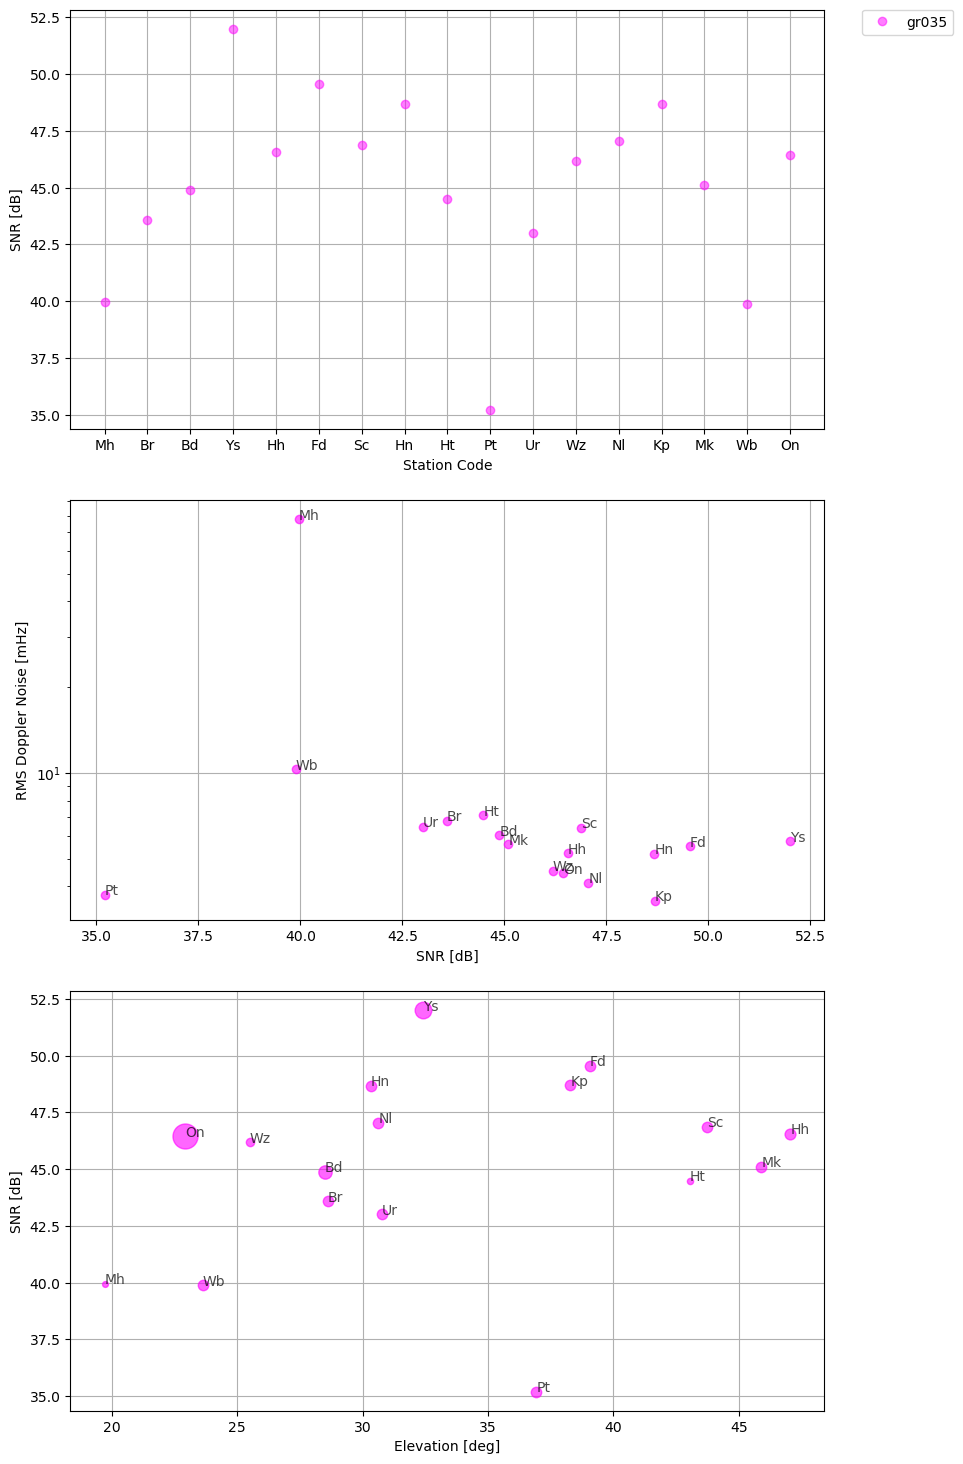

In [10]:
# Initialize labels and plot
labels_snr = set()
labels_doppler = set()
labels_snr_vs_noise = set()
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=False)
ax1, ax2, ax3 = axes  # Assign subplots
# Plotting results
count = 0
count_bad = 0
scans_to_remove = defaultdict(list)
for experiment_name in mean_rms_user_defined_parameters.keys():
    for station_dict in mean_rms_user_defined_parameters[experiment_name]:
        for station in station_dict.keys():
            try:
                antenna_diameter = utilities.antenna_diameters[station]
            except:
                continue
            mean_snr = 10*np.log10(station_dict[station]['mean_snr']) #in dB units
            rms_snr = 10*np.log10(station_dict[station]['rms_snr']) #in dB units
            mean_doppler = station_dict[station]['mean_doppler_noise']*1000 #convert to mHz
            rms_doppler = station_dict[station]['rms_doppler_noise']*1000 #convert to mHz
            mean_elevation = station_dict[station]['mean_elevation']
            if mission_name == 'vex':
                label = 'Venus Express 2014/01' if 'Venus Express 2014/01' not in labels_snr else None

            else:
                label = experiment_name if experiment_name not in labels_snr else None
            color = color_dict[experiment_name]
            count+=1
            labels_snr.add(label)
            labels_snr_vs_noise.add(label)
            # only keep good observations
            if np.abs(mean_doppler) > bad_observations_mean_doppler_filter*1000 and mission_name != 'mro': # in mHz:
                if BAD_OBSERVATIONS_FLAG:
                    count_bad +=1
                    print(f'Bad Observation: {station}, {experiment_name}')
                    scans_to_remove[experiment_name].append(station)
                    ax1.errorbar(station, mean_snr, fmt='x', markersize=6, alpha=0.7, color='red')
                    ax1.errorbar(station, mean_snr, fmt='o', linewidth=2, markersize=6, alpha=0.5,
                                 color=color, label=label)
                    ax2.errorbar(mean_snr, rms_doppler, fmt='x', markersize=6, alpha=0.7, color='red')
                    ax2.errorbar(mean_snr, rms_doppler, fmt='o', markersize=6, alpha=0.6,
                                 color=color, label=label)
                    ax2.annotate(station, (mean_snr, rms_doppler), fontsize=7, alpha=0.7)
                    ax3.errorbar(mean_elevation, mean_snr, fmt='x', markersize=3 * antenna_diameter / 10, alpha=0.7, color='red')
                    ax3.errorbar(mean_elevation, mean_snr, fmt='o', markersize=3 * antenna_diameter / 10, alpha=0.6,
                                 color=color, label=label)
                    ax3.annotate(station, (mean_elevation, mean_snr), fontsize=6, alpha=0.7)
                continue

            # Plot SNR on the first subplot
            ax1.errorbar(station, mean_snr, linewidth=2, fmt='o', markersize=6, alpha=0.5,
                         color=color, label = label)
            ax2.errorbar(mean_snr, rms_doppler, fmt='o',markersize=6, alpha=0.6,
                         color=color, label = label)
            ax2.annotate(station, (mean_snr, rms_doppler), fontsize=10, alpha=0.7)
            ax3.errorbar(mean_elevation, mean_snr, fmt='o', markersize=3*antenna_diameter/10, alpha=0.6,
                         color=color, label = label)
            ax3.annotate(station, (mean_elevation, mean_snr), fontsize=10, alpha=0.7)

# Final plot adjustments
ax1.set_ylabel('SNR [dB]')
ax1.set_xlabel(f'Station Code')
ax1.grid(True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Formatting SNR vs. Doppler Noise subplot
ax2.set_xlabel('SNR [dB]')
ax2.set_ylabel('RMS Doppler Noise [mHz]')
ax2.grid(True)
ax2.set_yscale('log')
# Formatting SNR vs. Doppler Noise subplot
ax3.set_xlabel('Elevation [deg]')
ax3.set_ylabel('SNR [dB]')
ax3.grid(True)
plt.savefig(output_dir + experiment_name + '_dataset_statistics.png')
plt.tight_layout(pad=2)
plt.show()

In [11]:
bad_observations_percentage = (count_bad/count)*100
if BAD_OBSERVATIONS_FLAG:
    print(f"Percentage of Bad Scans for {mission_name.upper()}: {bad_observations_percentage} %")

Percentage of Bad Scans for MEX: 0.0 %


# FoMs Computation 

This part of the code computes the mean values of the Figures of Merit (FoMs) among all stations belonging to a given experiment, and it does so by weighting the noise by its SNR.

In [12]:
mission_aggregates = defaultdict(lambda: {
    'mean_snr': [],
    'mean_doppler_noise': [],
    'rms_doppler_noise': []
})

In [13]:
original_data_dict = copy.deepcopy(mean_rms_user_defined_parameters)

In [14]:
for exp_name, stations_to_remove in scans_to_remove.items():
    if exp_name in mean_rms_user_defined_parameters:
        # Filter out the unwanted stations from the list
        mean_rms_user_defined_parameters[exp_name] = [
            station_data for station_data in mean_rms_user_defined_parameters[exp_name]
            if list(station_data.keys())[0] not in stations_to_remove
        ]
        # Remove experiments left with no stations
        mean_rms_user_defined_parameters = {k: v for k, v in mean_rms_user_defined_parameters.items() if v}

In [15]:
for exp_name, original_entries in original_data_dict.items():
    filtered_entries = mean_rms_user_defined_parameters.get(exp_name, [])
    # Get sets of station names
    original_stations = {list(entry.keys())[0] for entry in original_entries}
    filtered_stations = {list(entry.keys())[0] for entry in filtered_entries}

    removed_stations = original_stations - filtered_stations
    if removed_stations:
        print("=== Removed Stations ===")
        print(f"Experiment: {exp_name}")
        for station in removed_stations:
            print(f"  Removed Station: {station}")

In [16]:
for experiment_name in mean_rms_user_defined_parameters.keys():
    mission_name = utilities.get_mission_from_experiment(experiment_name)

    if mission_name is None:
        mission_name = 'vex'

    elif 'mro' in mission_name:
        mission_name = 'mro'

    # First step: Unweighted means
    aggregate = defaultdict(lambda: {'sum': 0, 'count': 0})
    for entry in mean_rms_user_defined_parameters[experiment_name]:
        for station, values in entry.items():
            for key, value in values.items():
                if key not in ['mean_doppler_noise', 'rms_doppler_noise']:
                    aggregate[key]['sum'] += value
                    aggregate[key]['count'] += 1

    mean_values_old = {key: aggregate[key]['sum'] / aggregate[key]['count'] for key in aggregate}
    # Second step: Weighted means using SNR
    aggregate_weighted = defaultdict(lambda: {'sum': 0, 'count': 0})
    for entry in mean_rms_user_defined_parameters[experiment_name]:
        for station, values in entry.items():
            snr_weight = values.get('mean_snr', 0)
            doppler = values.get('mean_doppler_noise', 0)
            if np.abs(doppler) > bad_observations_mean_doppler_filter:
                if BAD_OBSERVATIONS_FLAG and mission_name != 'mro': # exclude mro because of one-way doppler (higher RMS expected)
                    print(f'Skipping station {station} for experiment {experiment_name}')
                    continue
            for key, value in values.items():
                if key in ['mean_doppler_noise', 'rms_doppler_noise']:
                    aggregate_weighted[key]['sum'] += value * snr_weight
                    aggregate_weighted[key]['count'] += snr_weight

    mean_values_new = {
        key: (aggregate_weighted[key]['sum'] / aggregate_weighted[key]['count']) * 1000
        for key in aggregate_weighted
    }

    mission_aggregates[mission_name]['mean_snr'].append(mean_values_old['mean_snr'])
    for key in ['mean_doppler_noise', 'rms_doppler_noise']:
        if key in mean_values_new:
            mission_aggregates[mission_name][key].append(mean_values_new[key])

In [17]:
final_means_per_mission = {
    mission: {
        key: np.mean(values) if values else None
        for key, values in foms.items()
    }
    for mission, foms in mission_aggregates.items()
}

In [18]:
# Optional: Print results (these are the ones found in table 5 of Vidhya's paper).
for mission, foms in final_means_per_mission.items():
    print(f"\nMission: {mission}")
    if not BAD_OBSERVATIONS_FLAG:
        print('The folllowing values refer to the UNFILTERED dataset (no z-score).')
        print(f"Mean SNR (dB): {10 * np.log10(foms['mean_snr']) if foms['mean_snr'] else 'N/A'}")
        print(f"Mean Doppler Noise (mHz): {foms['mean_doppler_noise']}")
        print(f"RMS Doppler Noise (mHz): {foms['rms_doppler_noise']}")
    else:
        print('The folllowing values refer to the FILTERED dataset (z-score).')
        print(f"Mean SNR (dB): {10 * np.log10(foms['mean_snr']) if foms['mean_snr'] else 'N/A'}")
        print(f"Mean Doppler Noise (mHz): {foms['mean_doppler_noise']}")
        print(f"RMS Doppler Noise (mHz): {foms['rms_doppler_noise']}")


Mission: mex
The folllowing values refer to the FILTERED dataset (z-score).
Mean SNR (dB): 46.63602180853981
Mean Doppler Noise (mHz): 0.06681224158922769
RMS Doppler Noise (mHz): 6.292021213415723
